## Analysis of the FVA results for the Octanoate Base Case 
(limited oxygen and nitrogen uptake, c-source is octanoate and pha is produced)

### setup

In [1]:
import extFunc as ext
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import numpy as np
from importlib import import_module
import pandas as pd 
import cobra
import seaborn as sns
import optlang
import copy 
import random

In [2]:
%%capture
#Load Models if not already in RAM

#nameList = ['iJN1462_GLC_UR10_9.xml' , 'iJN1462_GLC_UR6_3.xml', 'iJN1462_GLN_UR5_1.xml', 'iJN1462_GLC_UR7_3.xml' , 'iJN1462_OCT_UR3_4.xml']
#nameList = ['iJN1462_GLC_UR6_3.xml' , 'iJN1462_OCT_UR3_4.xml']
nameList = ['iJN1462_GLC_UR6_3.xml']

if 'modelDict' not in locals():
    modelDict = ext.ImportFunction(nameList)



if 'glc_oct_comp'  not in locals():
    glc_oct_comp = ext.ModelComparison(modelDict=modelDict)


Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


## FVA analysis


In [3]:
%%capture
#Base case as in Nogales Paper
model           = modelDict['iJN1462_GLC_UR6_3']
model_bounded   = copy.deepcopy(model)

fv                  = cobra.flux_analysis.flux_variability_analysis(model)
fv["cumulative"]    = abs(fv.maximum) + abs(fv.minimum)


## FVA analysis, Plotting FVA, filterig extreme FVA, influnce of the filtered?


### filtering reactions fva>200 
Assumption through high default boundaries overal variability artificially strethed ?
Test, Measure the overall cumulative variability for the bounded and unbound optimized cases.
If a difference is visible after removig the artificially stretched reactions, this would mean that theire was an influence

length of the filtered array = 173


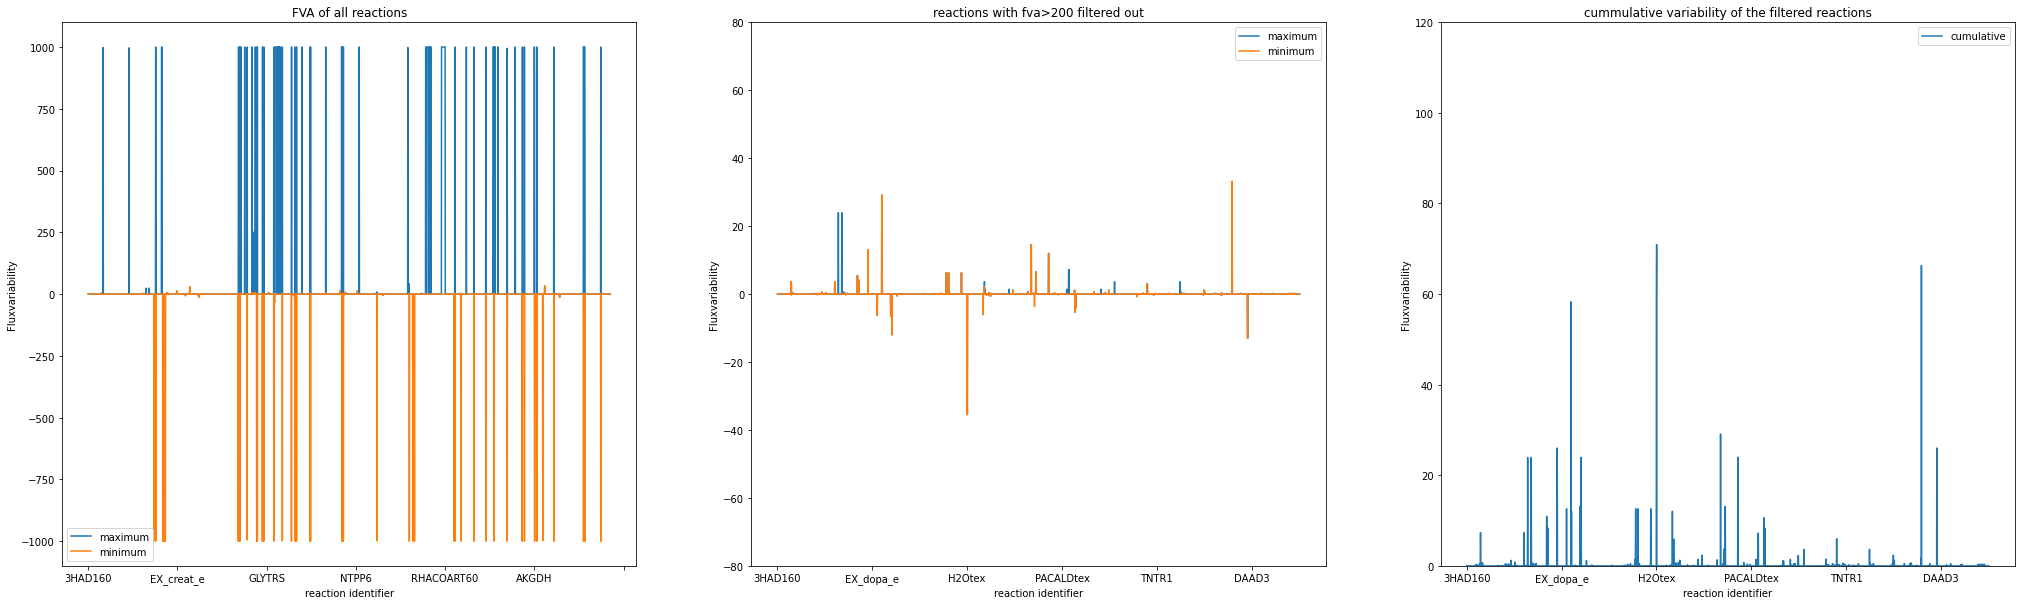

In [4]:
filterV = 40

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(35,10))
fv.plot( y=["maximum", "minimum"],ax=axes[0],
        ylabel="Fluxvariability",
        xlabel="reaction identifier",
        title="FVA of all reactions")
fv[(abs(fv.maximum)<filterV) & (abs(fv.minimum)<filterV)].plot( y=["maximum", "minimum"],
        ax=axes[1],ylim=[-80,80],
        ylabel="Fluxvariability",
        xlabel="reaction identifier",
        title="reactions with fva>200 filtered out")
fv[(abs(fv.maximum)<filterV) & (abs(fv.minimum)<filterV)].plot( y=["cumulative"],
        ax=axes[2],ylim=[0,120],
        ylabel="Fluxvariability",
        xlabel="reaction identifier",
        title="cummulative variability of the filtered reactions")

## save list of filtered for later

list_of_filtered = fv[(abs(fv.maximum)>filterV) | (abs(fv.minimum)>filterV)]
print("length of the filtered array = "+str(len(list_of_filtered)))
#print(list_of_filtered.index)


In [5]:

bounded_model = copy.deepcopy(model)

for reaction in bounded_model.reactions:
    if abs(reaction.lower_bound)>filterV:
        reaction.lower_bound= filterV*np.sign(reaction.lower_bound)
    if abs(reaction.upper_bound)>filterV:
        reaction.upper_bound =  filterV *np.sign(reaction.upper_bound)
        
fv_new_model  = cobra.flux_analysis.flux_variability_analysis(bounded_model)
fv_new_model["cumulative"]    = abs(fv_new_model.maximum) + abs(fv_new_model.minimum)

<AxesSubplot:title={'center':'cummulative fva values'}, xlabel='reaction identifier', ylabel='Fluxvariability'>

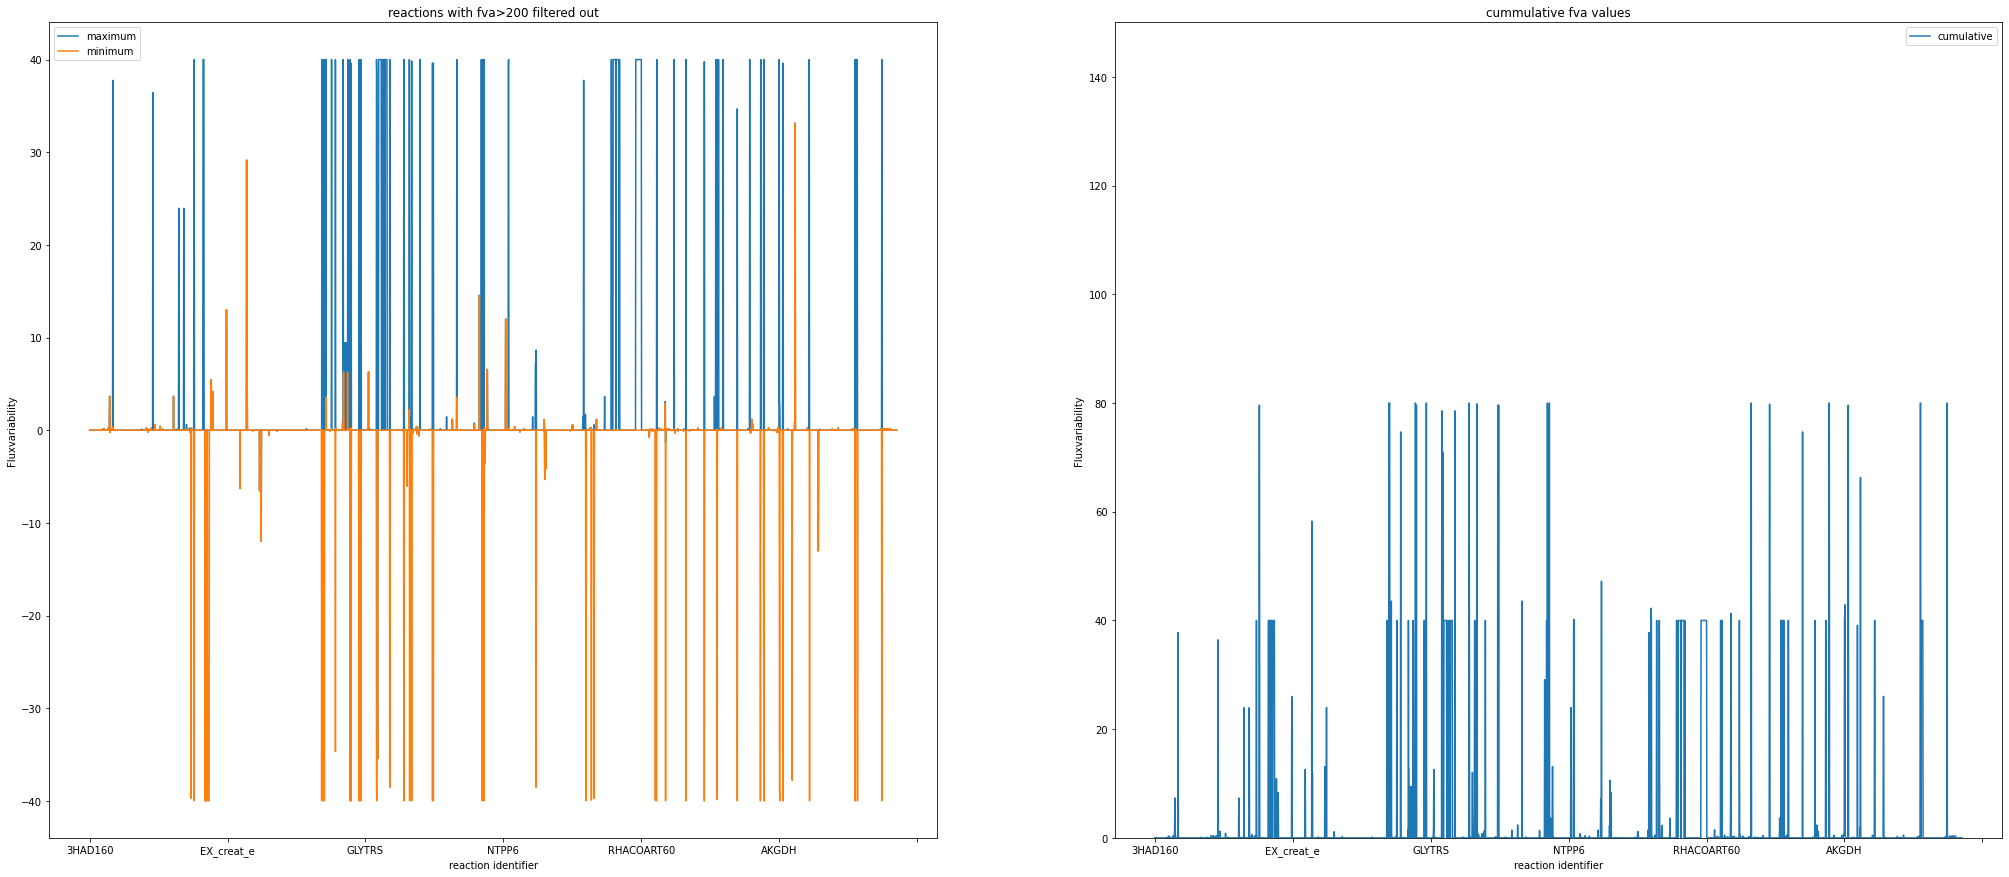

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fv_new_model.plot( 
        y=["maximum", "minimum"],
        ax=axes[0],figsize=(35,15),
        ylabel="Fluxvariability",
        xlabel="reaction identifier",
        title="reactions with fva>200 filtered out"
        )
fv_new_model.plot( 
        y=["cumulative"],
        ax=axes[1],ylim=[0,150],
        ylabel="Fluxvariability",
        xlabel="reaction identifier",
        title="cummulative fva values"
        )


#### Assumption through high default boundaries overal variability artificially strethed ?
#### Test, Measure the overall cumulative variability for the bounded and unbound optimized cases.
#### If a difference is visible after removig the artificially stretched reactions, this would mean that theire was an influence

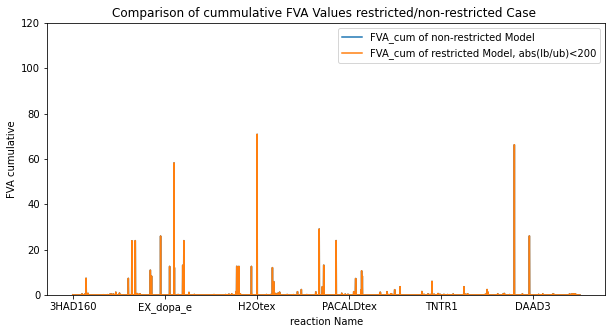

In [7]:
filter = list_of_filtered.index

ax1 =   fv[~fv.index.isin(filter)].plot( y=["cumulative"],ylim=[0,120])
fv_new_model[~fv_new_model.index.isin(filter)].plot( y=["cumulative"],ax=ax1,
title = "Comparison of cummulative FVA Values restricted/non-restricted Case ",
xlabel = "reaction Name",
ylabel = "FVA cumulative"
)

ax1.legend(["FVA_cum of non-restricted Model", "FVA_cum of restricted Model, abs(lb/ub)<200"])



Number of reactions,for which the result of the FVA changed through reducing the biggest boundaries 0
seems as if a signifant account might be numerical, because of small differences 


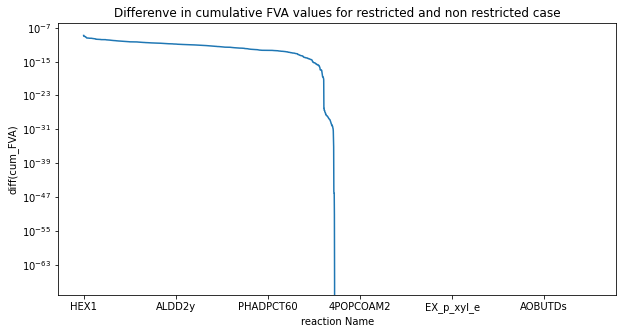

In [8]:
diff=fv[~fv.index.isin(filter)]["cumulative"] - fv_new_model[~fv_new_model.index.isin(filter)]["cumulative"]
diff.sort_values(ascending=False).plot(logy=True,
title = "Differenve in cumulative FVA values for restricted and non restricted case",
xlabel = "reaction Name",
ylabel = "diff(cum_FVA)"
)
nonzero_diff = diff[diff > 1e-5]

print("Number of reactions,for which the result of the FVA changed through reducing the biggest boundaries " + str(len(nonzero_diff)))
print("seems as if a signifant account might be numerical, because of small differences ")

In [9]:
print(nonzero_diff)

Series([], Name: cumulative, dtype: float64)


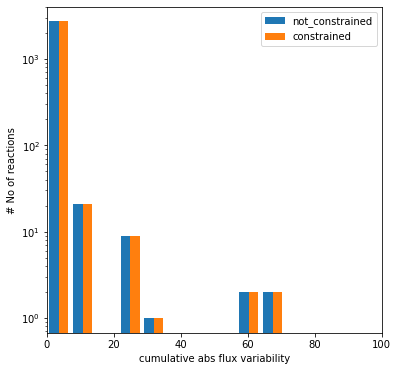

In [10]:
#bin_array = np.logspace(1e-4,1e+4,9)
#axA = fv[~fv.index.isin(filter)].hist(column=["cumulative"],log=True, bins=50,figsize=(5,5))
#fv_new_model[~fv_new_model.index.isin(filter)].hist(column=["cumulative"] , log=True,bins=50,ax=axA)
comp = pd.DataFrame()
comp['notConstrained']=fv[~fv.index.isin(filter)]["cumulative"]
comp['constrained']=fv_new_model[~fv_new_model.index.isin(filter)]["cumulative"]

fig=plt.figure(figsize=(6,6))
 
plt.xlabel('cumulative abs flux variability')
plt.ylabel('# No of reactions')
plt.xlim([0,100])
#plt.ylim(0,1e4)
plt.hist(comp,log=True,label=["not_constrained","constrained"])

plt.legend()




### comparing flux distribution for the filtered and not filtered case

In [11]:


modelDict2 = {
    "baseCaseOctanoat" : model ,
    "boundariesLimited to +/- 200" : bounded_model 
    }
comparisonObjectBoundaedModels = ext.ModelComparison(modelDict=modelDict2)
comparisonObjectBoundaedModels.multiModellSummary(fvaDIr=.99,sortKrit='C-Flux')

Uptake                          \
                                metabolite      reaction      flux   
baseCaseOctanoat             0   glc__D[e]   EX_glc__D_e  6.300000   
                             1  pqqA_kt[c]  SK_pqqA_kt_c  0.000137   
                             2      na1[e]      EX_na1_e  0.002168   
                             3      zn2[e]      EX_zn2_e  0.001734   
                             4      so4[e]      EX_so4_e  0.114504   
boundariesLimited to +/- 200 0   glc__D[e]   EX_glc__D_e  6.300000   
                             1  pqqA_kt[c]  SK_pqqA_kt_c  0.000137   
                             2      na1[e]      EX_na1_e  0.002168   
                             3      zn2[e]      EX_zn2_e  0.001734   
                             4      so4[e]      EX_so4_e  0.114504   

                                                                                  \
                                                                           range   
baseCaseOctanoat             0                          (6.299999999993848, 6.3)   
                             1  (0.00013728582221364972, 0.00013728582221377494)   
                             2     (0.0021682541068900178, 0.002168254106894571)   
                             3     (0.0017342339066181663, 0.001734233906621996)   
                             4        (0.11450376330405945, 0.11450376337845493)   
boundariesLimited to +/- 200 0                          (6.299999999999995, 6.3)   
                             1  (0.00013728582221378394, 0.00013728582221378378)   
                             2     (0.0021682541068921393, 0.002168254106892165)   
                             3    (0.0017342339066198625, 0.0017342339066198822)   
                             4        (0.11450376330417125, 0.11450376330455932)   

                                                        Secretion  \
                               C-Number     C-Flux     metabolite   
baseCaseOctanoat             0        6  99.994916         co2[e]   
                             1       14   0.005084       5drib[c]   
                             2        0   0.000000        amob[c]   
                             3        0   0.000000      doxopa[c]   
                             4        0   0.000000  tripeptide[c]   
boundariesLimited to +/- 200 0        6  99.994916         co2[e]   
                             1       14   0.005084       5drib[c]   
                             2        0   0.000000        amob[c]   
                             3        0   0.000000      doxopa[c]   
                             4        0   0.000000  tripeptide[c]   

                                                            \
                                       reaction       flux   
baseCaseOctanoat             0         EX_co2_e -13.008062   
                             1       DM_5drib_c  -0.000412   
                             2        DM_amob_c  -0.000137   
                             3      DM_doxopa_c  -0.000137   
                             4  DM_tripeptide_c  -0.000137   
boundariesLimited to +/- 200 0         EX_co2_e -13.008062   
                             1       DM_5drib_c  -0.000412   
                             2        DM_amob_c  -0.000137   
                             3      DM_doxopa_c  -0.000137   
                             4  DM_tripeptide_c  -0.000137   

                                                                                   \
                                                                            range   
baseCaseOctanoat             0          (-13.008062493678919, -13.00806249313996)   
                             1    (-0.0004118574707388604, -0.000411857466640949)   
                             2  (-0.00013728582282382935, -0.00013728582221364...   
                             3  (-0.00013728582256783694, -0.0001372858222136497)   
                             4  (-0.00013728582221378323, -0.0001372858222136497)   
boundariesLimited

## Analysis of the reactions which are filtered

In [12]:
fl = bounded_model.optimize().fluxes
fl[abs(fl)>5]

CYTBO3_4pp     23.940250
EDA             5.450198
EDD             5.450198
EX_co2_e       13.008062
EX_glc__D_e    -6.300000
EX_h2o_e       29.145795
EX_h_e          6.026947
EX_nh4_e       -6.552884
EX_o2_e       -11.985289
GLCDpp          6.300000
GLCNt2rpp       6.300000
GLCtex          6.300000
GNK             6.300000
H2Otex        -29.145795
H2Otpp        -35.460864
Htex           -6.026947
MDH             5.008337
NADH16pp       14.557777
NH4tex          6.552884
NH4tpp          6.552884
O2tex          11.985289
O2tpp          11.983029
PDHa            7.206496
PDHbr           7.206496
PGK            -5.317732
AKGDH           8.650809
AKGDa          -7.206496
AKGDb_copy1    -7.206496
ATPS4rpp       33.154423
CO2tex        -13.008062
CO2tpp        -13.008062
Name: fluxes, dtype: float64

<AxesSubplot:title={'center':'Flux results of the filtered reactions'}, ylabel='Frequency'>

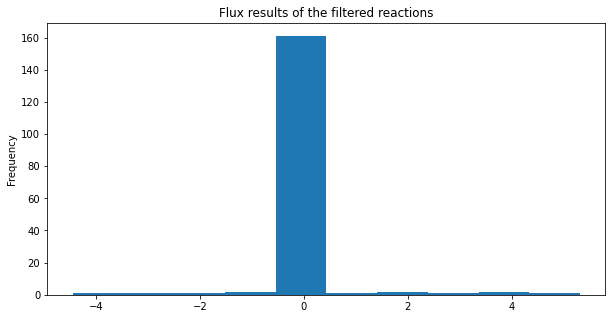

In [13]:
fl = model.optimize().fluxes
fl[list_of_filtered.index].plot.hist(
    title="Flux results of the filtered reactions",
    xlabel="Fluxvalues ")

### Are theire exchange reactions being filtered out 

In [14]:
list_of_filtered.index = list_of_filtered.index.astype('str')
list_of_filtered[list_of_filtered.index.str.contains('EX')]

,minimum,maximum,cumulative


## Analysis of FVA of the reaction which are on the Carbon conversion Path

In [15]:

octanoate_path_reaction_ids =   ["GLC_tex", "FACOAL80t2pp", "ACOAD3f","RECOAH3", "ACSPHAC80","PHADPC80","DM_C80aPHA_c"]
ind_nr                      =   [6, 4 , 1, 3, 2,5,7]
fv_main_carbonpath = fv[fv.index.isin(octanoate_path_reaction_ids)]
fv_main_carbonpath.loc[:,"ind_nr"] = ind_nr
fv_main_carbonpath.sort_values("ind_nr").plot.bar(y=['minimum',])

ValueError: Length of values (7) does not match length of index (6)